# 2021 Introduction to Machine Learning Final Project

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import prettytable
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import keras
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint

# Data Input
- arff檔案轉成csv檔

In [69]:
# Importing library
import os

# Getting all the arff files from the current directory
files = [arff for arff in os.listdir('.') if arff.endswith(".arff")]

# Function for converting arff list to csv list
def toCsv(text):
    data = False
    header = ""
    new_content = []
    for line in text:
        if not data:
            if "@ATTRIBUTE" in line or "@attribute" in line:
                attributes = line.split()
                if("@attribute" in line):
                    attri_case = "@attribute"
                else:
                    attri_case = "@ATTRIBUTE"
                column_name = attributes[attributes.index(attri_case) + 1]
                header = header + column_name + ","
            elif "@DATA" in line or "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                new_content.append(header)
        else:
            new_content.append(line)
    return new_content


# Main loop for reading and writing files
for file in files:
    with open(file, "r") as inFile:
        content = inFile.readlines()
        name, ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open(name + ".csv", "w") as outFile:
            outFile.writelines(new)

In [70]:
df=pd.read_csv('C:/Users/Suyin/Desktop/ML_Final/chronic_kidney_disease.csv',error_bad_lines=False, engine ='python')

Skipping line 72: Expected 25 fields in line 72, saw 26
Skipping line 75: Expected 25 fields in line 75, saw 26
Skipping line 372: Expected 25 fields in line 372, saw 26


# Data preprocessing

In [71]:
#把columns的''單引號去掉
df = df.rename(columns=lambda x: x.replace("'","").replace('"','')).replace(" ","")

In [72]:
#把missing value的'?'改成NaN較好處理
data = df.replace(to_replace='?',value=np.nan)
data = data.replace(to_replace='\t?',value=np.nan)

In [73]:
data.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']

In [74]:
data.describe()

age blood_pressure specific_gravity albumin sugar red_blood_cells  \
count   388            385              350     351   348             247   
unique   75             10                5       6     6               2   
top      60             80            1.020       0     0          normal   
freq     19            116              105     197   289             200   

       pus_cell pus_cell_clumps    bacteria blood_glucose_random  ...  \
count       332             393         393                  354  ...   
unique        2               2           2                  145  ...   
top      normal      notpresent  notpresent                   99  ...   
freq        257             352         371                   10  ...   

       packed_cell_volume white_blood_cell_count red_blood_cell_count  \
count                 327                    292                  267   
unique                 43                     91                   48   
top                    41                   9800                  5.2   
freq                   21                     11                   18   

       hypertension diabetes_mellitus coronary_artery_disease appetite  \
count           395               395                     395      396   
unique            2                 5                       3        2   
top              no                no                      no     good   
freq            249               257                     359      314   

       peda_edema aanemia class  
count         396     396   397  
unique          2       2     3  
top            no      no   ckd  
freq          321     336   246  

[4 rows x 25 columns]

In [76]:
#某些column的numeric值被用string type儲存了，to_numeric沒辦法轉，所以自己手動轉

mistyped=['packed_cell_volume','white_blood_cell_count','red_blood_cell_count','age','blood_pressure','specific_gravity','albumin',
          'sugar','sodium','blood_glucose_random','blood_urea','serum_creatinine','potassium','haemoglobin']
numeric=[]
for i in data.columns:
    if data[i].dtype=='float64':
        numeric.append(i)
numeric=numeric+mistyped

In [77]:
for col in mistyped:
        data[col]=data[col].astype('float')

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      388 non-null    float64
 1   blood_pressure           385 non-null    float64
 2   specific_gravity         350 non-null    float64
 3   albumin                  351 non-null    float64
 4   sugar                    348 non-null    float64
 5   red_blood_cells          247 non-null    object 
 6   pus_cell                 332 non-null    object 
 7   pus_cell_clumps          393 non-null    object 
 8   bacteria                 393 non-null    object 
 9   blood_glucose_random     354 non-null    float64
 10  blood_urea               378 non-null    float64
 11  serum_creatinine         380 non-null    float64
 12  sodium                   312 non-null    float64
 13  potassium                311 non-null    float64
 14  haemoglobin              3

In [79]:
# Extracting categorical and numerical columns

categorical = [i for i in data.columns if data[i].dtype == 'object']
numeric = [j for j in data.columns if data[j].dtype != 'object']

In [80]:
#檢查數據，發現有些data包含\t，會影響訓練
for col in categorical:
    print(f"{col} has {data[col].unique()} values\n")

red_blood_cells has [nan 'normal' 'abnormal'] values

pus_cell has ['normal' 'abnormal' nan] values

pus_cell_clumps has ['notpresent' 'present' nan] values

bacteria has ['notpresent' 'present' nan] values

hypertension has ['yes' 'no' nan] values

diabetes_mellitus has ['yes' 'no' ' yes' '\tno' '\tyes' nan] values

coronary_artery_disease has ['no' 'yes' '\tno' nan] values

appetite has ['good' 'poor' nan] values

peda_edema has ['no' 'yes' nan] values

aanemia has ['no' 'yes' nan] values

class has ['ckd' 'ckd\t' 'notckd'] values



In [81]:
data['diabetes_mellitus']=data['diabetes_mellitus'].replace(to_replace={ '\tno':'no','\tyes':'yes',' yes':'yes'})
data['coronary_artery_disease']=data['coronary_artery_disease'].replace(to_replace={'\tno':'no'})
data['class']=data['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [82]:
#number of null values

data.isnull().sum()

age                          9
blood_pressure              12
specific_gravity            47
albumin                     46
sugar                       49
red_blood_cells            150
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        43
blood_urea                  19
serum_creatinine            17
sodium                      85
potassium                   86
haemoglobin                 52
packed_cell_volume          70
white_blood_cell_count     105
red_blood_cell_count       130
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

In [83]:
#mean:then replace missing values using the mean along each column. Can only be used with numeric data.
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data[numeric])

num_df=pd.DataFrame(imp_mean.transform(data[numeric]))
num_df.columns=numeric
num_df

age  blood_pressure  specific_gravity  albumin  sugar  \
0    48.0            80.0             1.020      1.0    0.0   
1     7.0            50.0             1.020      4.0    0.0   
2    62.0            80.0             1.010      2.0    3.0   
3    48.0            70.0             1.005      4.0    0.0   
4    51.0            80.0             1.010      2.0    0.0   
..    ...             ...               ...      ...    ...   
392  55.0            80.0             1.020      0.0    0.0   
393  42.0            70.0             1.025      0.0    0.0   
394  12.0            80.0             1.020      0.0    0.0   
395  17.0            60.0             1.025      0.0    0.0   
396  58.0            80.0             1.025      0.0    0.0   

     blood_glucose_random  blood_urea  serum_creatinine      sodium  \
0              121.000000        36.0               1.2  137.508013   
1              147.864407        18.0               0.8  137.508013   
2              423.000000        53.0               1.8  137.508013   
3              117.000000        56.0               3.8  111.000000   
4              106.000000        26.0               1.4  137.508013   
..                    ...         ...               ...         ...   
392            140.000000        49.0               0.5  150.000000   
393             75.000000        31.0               1.2  141.000000   
394            100.000000        26.0               0.6  137.000000   
395            114.000000        50.0               1.0  135.000000   
396            131.000000        18.0               1.1  141.000000   

     potassium  haemoglobin  packed_cell_volume  white_blood_cell_count  \
0     4.630868         15.4                44.0                  7800.0   
1     4.630868         11.3                38.0                  6000.0   
2     4.630868          9.6                31.0                  7500.0   
3     2.500000         11.2                32.0                  6700.0   
4     4.630868         11.6                35.0                  7300.0   
..         ...          ...                 ...                     ...   
392   4.900000         15.7                47.0                  6700.0   
393   3.500000         16.5                54.0                  7800.0   
394   4.400000         15.8                49.0                  6600.0   
395   4.900000         14.2                51.0                  7200.0   
396   3.500000         15.8                53.0                  6800.0   

     red_blood_cell_count  
0                5.200000  
1                4.702247  
2                4.702247  
3                3.900000  
4                4.600000  
..                    ...  
392              4.900000  
393              6.200000  
394              5.400000  
395              5.900000  
396              6.100000  

[397 rows x 14 columns]

In [84]:
#most_frequent:then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned. 
imp_fre = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
imp_fre.fit(data[categorical])

cate_df=pd.DataFrame(imp_fre.transform(data[categorical])) 
cate_df.columns=categorical 
cate_df

red_blood_cells  pus_cell pus_cell_clumps    bacteria hypertension  \
0            normal    normal      notpresent  notpresent          yes   
1            normal    normal      notpresent  notpresent           no   
2            normal    normal      notpresent  notpresent           no   
3            normal  abnormal         present  notpresent          yes   
4            normal    normal      notpresent  notpresent           no   
..              ...       ...             ...         ...          ...   
392          normal    normal      notpresent  notpresent           no   
393          normal    normal      notpresent  notpresent           no   
394          normal    normal      notpresent  notpresent           no   
395          normal    normal      notpresent  notpresent           no   
396          normal    normal      notpresent  notpresent           no   

    diabetes_mellitus coronary_artery_disease appetite peda_edema aanemia  \
0                 yes                      no     good         no      no   
1                  no                      no     good         no      no   
2                 yes                      no     poor         no     yes   
3                  no                      no     poor        yes     yes   
4                  no                      no     good         no      no   
..                ...                     ...      ...        ...     ...   
392                no                      no     good         no      no   
393                no                      no     good         no      no   
394                no                      no     good         no      no   
395                no                      no     good         no      no   
396                no                      no     good         no      no   

       class  
0        ckd  
1        ckd  
2        ckd  
3        ckd  
4        ckd  
..       ...  
392  not ckd  
393  not ckd  
394  not ckd  
395  not ckd  
396  not ckd  

[397 rows x 11 columns]

In [85]:
#Label encoding
le = LabelEncoder()

for col in categorical:
    cate_df[col] = le.fit_transform(cate_df[col])

In [86]:
input_data=pd.concat([cate_df,num_df],axis=1)
input_data

red_blood_cells  pus_cell  pus_cell_clumps  bacteria  hypertension  \
0                  1         1                0         0             1   
1                  1         1                0         0             0   
2                  1         1                0         0             0   
3                  1         0                1         0             1   
4                  1         1                0         0             0   
..               ...       ...              ...       ...           ...   
392                1         1                0         0             0   
393                1         1                0         0             0   
394                1         1                0         0             0   
395                1         1                0         0             0   
396                1         1                0         0             0   

     diabetes_mellitus  coronary_artery_disease  appetite  peda_edema  \
0                    1                        0         0           0   
1                    0                        0         0           0   
2                    1                        0         1           0   
3                    0                        0         1           1   
4                    0                        0         0           0   
..                 ...                      ...       ...         ...   
392                  0                        0         0           0   
393                  0                        0         0           0   
394                  0                        0         0           0   
395                  0                        0         0           0   
396                  0                        0         0           0   

     aanemia  ...  sugar  blood_glucose_random  blood_urea  serum_creatinine  \
0          0  ...    0.0            121.000000        36.0               1.2   
1          0  ...    0.0            147.864407        18.0               0.8   
2          1  ...    3.0            423.000000        53.0               1.8   
3          1  ...    0.0            117.000000        56.0               3.8   
4          0  ...    0.0            106.000000        26.0               1.4   
..       ...  ...    ...                   ...         ...               ...   
392        0  ...    0.0            140.000000        49.0               0.5   
393        0  ...    0.0             75.000000        31.0               1.2   
394        0  ...    0.0            100.000000        26.0               0.6   
395        0  ...    0.0            114.000000        50.0               1.0   
396        0  ...    0.0            131.000000        18.0               1.1   

         sodium  potassium  haemoglobin  packed_cell_volume  \
0    137.508013   4.630868         15.4                44.0   
1    137.508013   4.630868         11.3                38.0   
2    137.508013   4.630868          9.6                31.0   
3    111.000000   2.500000         11.2                32.0   
4    137.508013   4.630868         11.6                35.0   
..          ...        ...          ...                 ...   
392  150.000000   4.900000         15.7                47.0   
393  141.000000   3.500000         16.5                54.0   
394  137.000000   4.400000         15.8                49.0   
395  135.000000   4.900000         14.2                51.0   
396  141.000000   3.500000         15.8                53.0   

     white_blood_cell_count  red_blood_cell_count  
0                    7800.0              5.200000  
1                    6000.0              4.702247  
2                    7500.0              4.702247  
3                    6700.0              3.900000  
4                    7300.0              4.600000  
..                      ...                   ...  
392                  6700.0              4.900000  
393                  7800.0              6.200000  
394                  6600.0              

In [87]:
#Standardize

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(input_data[numeric])

input_data_std=input_data.copy()
input_data_std[numeric]=sc.transform(input_data[numeric])
input_data_std[numeric]

age  blood_pressure  specific_gravity   albumin     sugar  \
0   -0.204305        0.261949          0.479113 -0.013464 -0.430410   
1   -2.627936       -1.962694          0.479113  2.349523 -0.430410   
2    0.623276        0.261949         -1.384105  0.774198  2.545403   
3   -0.204305       -0.479598         -2.315713  2.349523 -0.430410   
4   -0.026966        0.261949         -1.384105  0.774198 -0.430410   
..        ...             ...               ...       ...       ...   
392  0.209485        0.261949          0.479113 -0.801127 -0.430410   
393 -0.558983       -0.479598          1.410722 -0.801127 -0.430410   
394 -2.332372        0.261949          0.479113 -0.801127 -0.430410   
395 -2.036807       -1.221146          1.410722 -0.801127 -0.430410   
396  0.386824        0.261949          1.410722 -0.801127 -0.430410   

     blood_glucose_random  blood_urea  serum_creatinine    sodium  \
0           -3.593066e-01   -0.437795         -0.335465  0.000000   
1           -3.801352e-16   -0.802472         -0.406527  0.000000   
2            3.679889e+00   -0.093377         -0.228872  0.000000   
3           -4.128058e-01   -0.032598          0.126439 -2.874528   
4           -5.599288e-01   -0.640393         -0.299934  0.000000   
..                    ...         ...               ...       ...   
392         -1.051850e-01   -0.174417         -0.459824  1.354631   
393         -9.745482e-01   -0.539094         -0.335465  0.378671   
394         -6.401777e-01   -0.640393         -0.442058 -0.055089   
395         -4.529303e-01   -0.154157         -0.370996 -0.271969   
396         -2.255584e-01   -0.802472         -0.353230  0.378671   

        potassium  haemoglobin  packed_cell_volume  white_blood_cell_count  \
0   -3.142539e-16     1.060143            0.636275               -0.239366   
1   -3.142539e-16    -0.449544           -0.101097               -0.951772   
2   -3.142539e-16    -1.075512           -0.961365               -0.358100   
3   -7.539404e-01    -0.486366           -0.838469               -0.674725   
4   -3.142539e-16    -0.339079           -0.469783               -0.437257   
..            ...          ...                 ...                     ...   
392  9.522380e-02     1.170608            1.004961               -0.674725   
393 -4.001220e-01     1.465181            1.865228               -0.239366   
394 -8.168541e-02     1.207429            1.250751               -0.714303   
395  9.522380e-02     0.618283            1.496542               -0.476835   
396 -4.001220e-01     1.207429            1.742333               -0.635147   

     red_blood_cell_count  
0                0.592631  
1                0.000000  
2                0.000000  
3               -0.955166  
4               -0.121737  
..                    ...  
392              0.235447  
393              1.783245  
394              0.830754  
395              1.426061  
396              1.664183  

[397 rows x 14 columns]

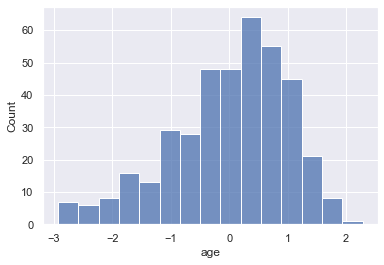

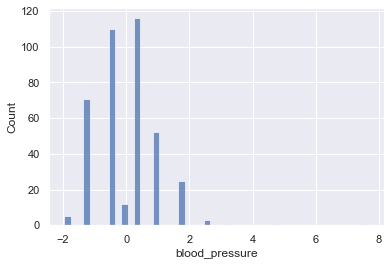

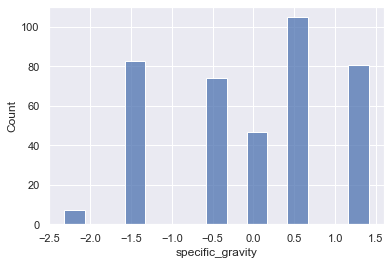

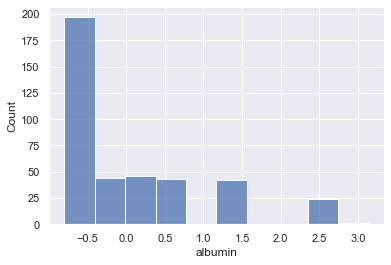

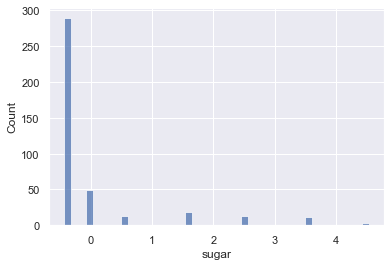

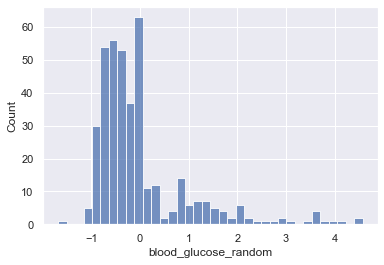

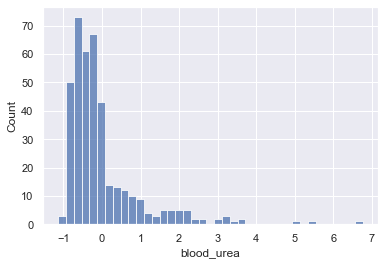

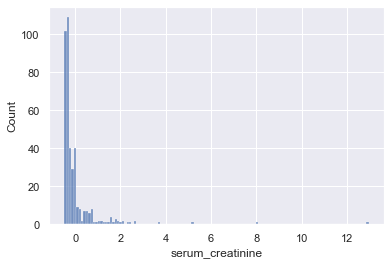

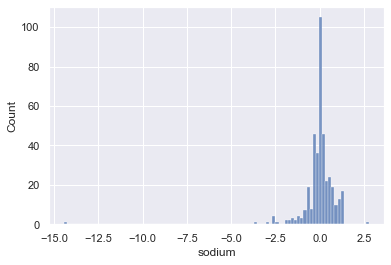

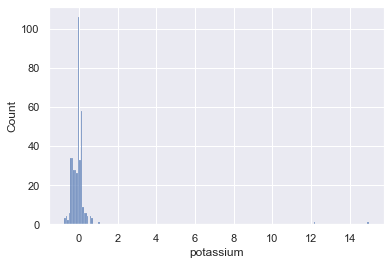

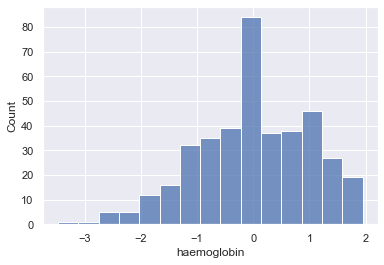

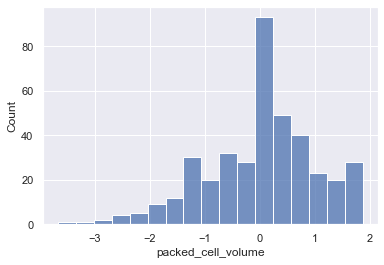

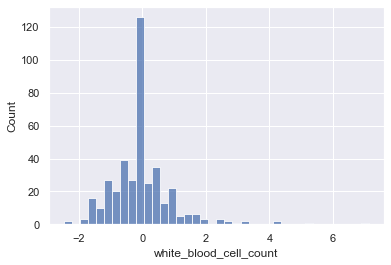

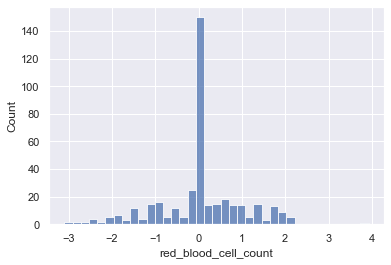

In [88]:
sns.set(style='darkgrid')

#histogram
for i, col in enumerate(numeric):
    plt.figure(i)
    sns.histplot(x=col, data=input_data_std)

# Data Visulization

- 展示原始數據，非處理過後的

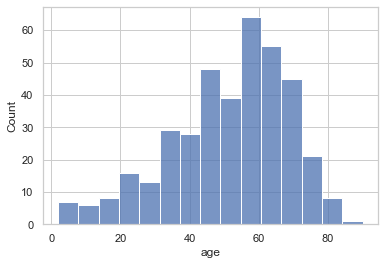

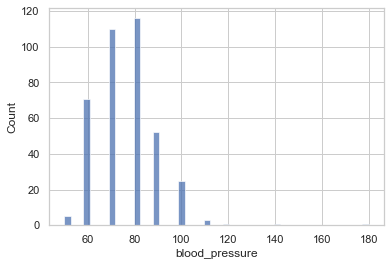

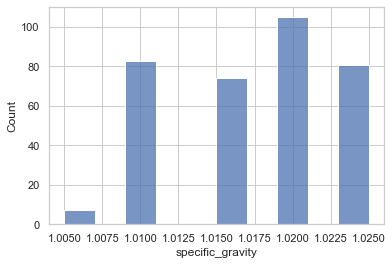

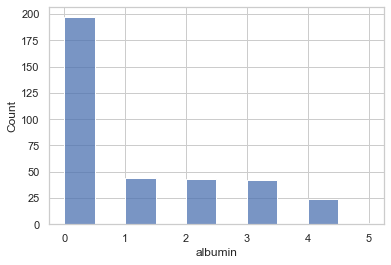

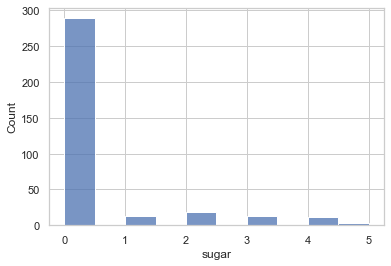

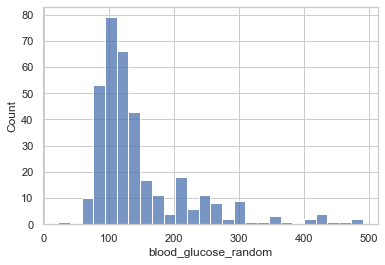

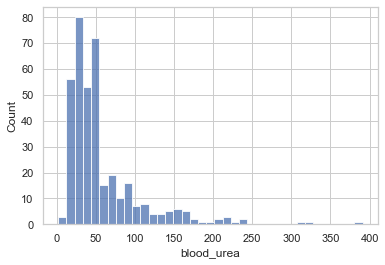

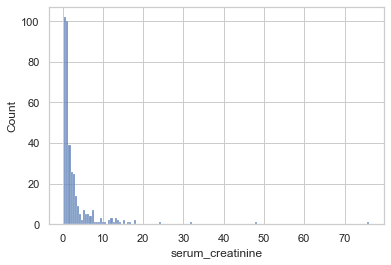

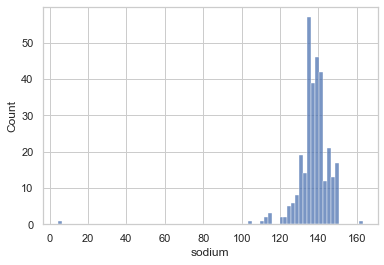

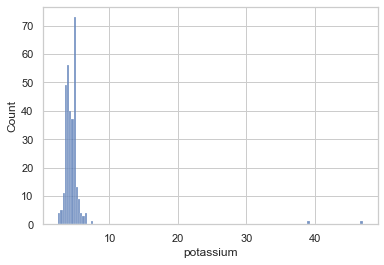

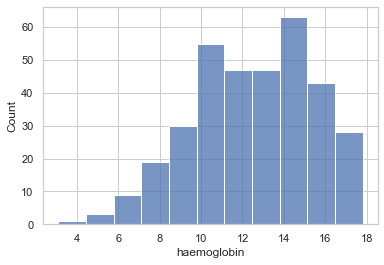

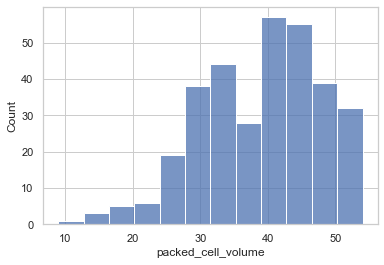

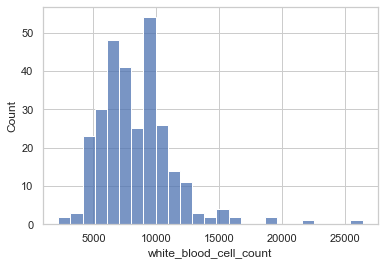

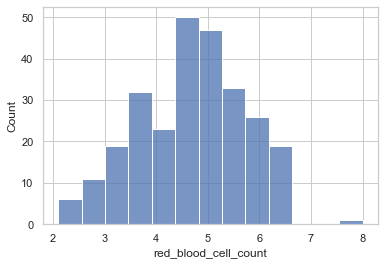

In [89]:
sns.set(style='whitegrid')

#histogram
for i, col in enumerate(numeric):
    plt.figure(i)
    sns.histplot(x=col, data=data)

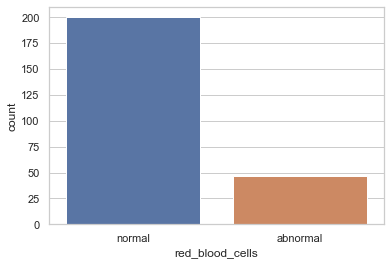

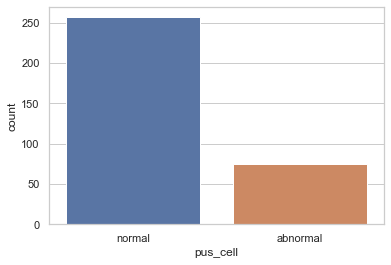

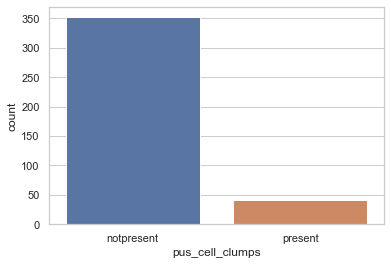

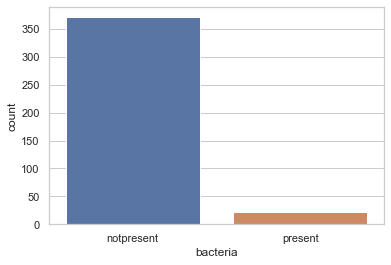

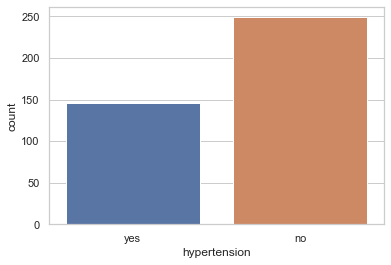

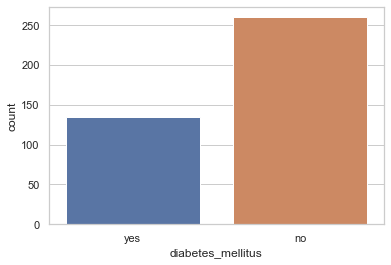

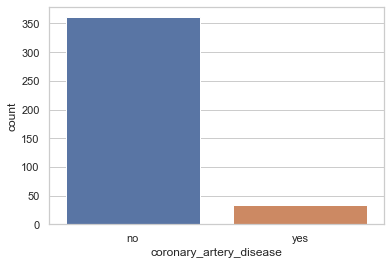

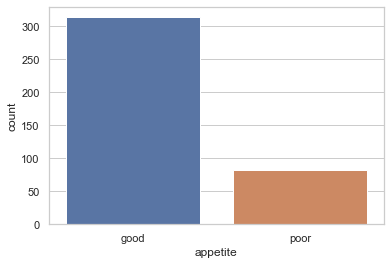

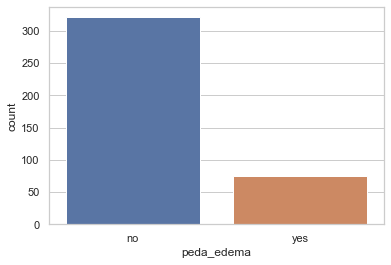

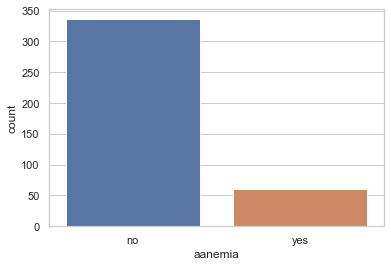

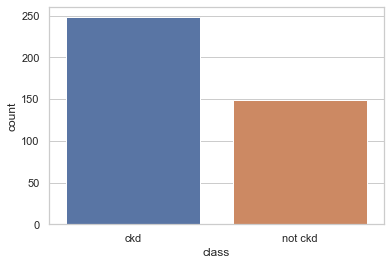

In [90]:
#bar chart
for i, col in enumerate(categorical):
    plt.figure(i)
    sns.countplot(x=col, data=data)

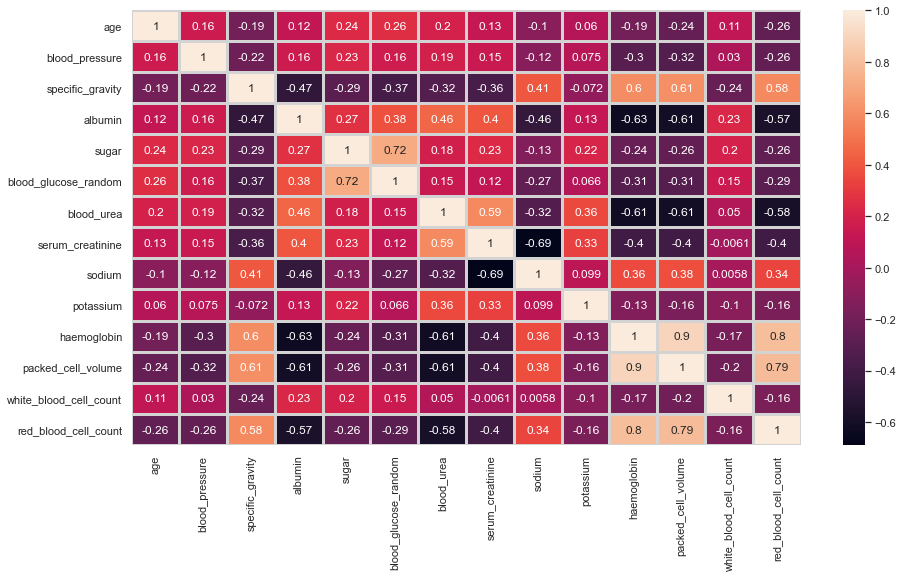

In [91]:
#heapmap
plt.figure(figsize = (15, 8))

sns.heatmap(data.corr(), annot = True, linewidths = 2, linecolor = 'lightgrey')
plt.show()

In [92]:
import plotly.express as px
def violin(col):
    fig = px.violin(data, y=col, x="class", color="class", box=True, template = 'plotly_dark')
    return fig.show()

def kde(col):
    grid = sns.FacetGrid(data, hue="class", height = 6, aspect=2)
    grid.map(sns.kdeplot, col)
    grid.add_legend()
    
def scatter(col1, col2):
    fig = px.scatter(data, x=col1, y=col2, color="class", template = 'plotly_dark')
    return fig.show()

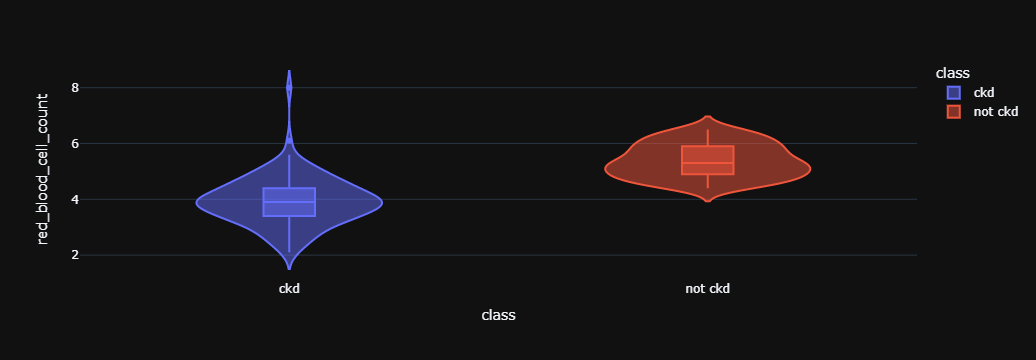

In [93]:
violin('red_blood_cell_count')

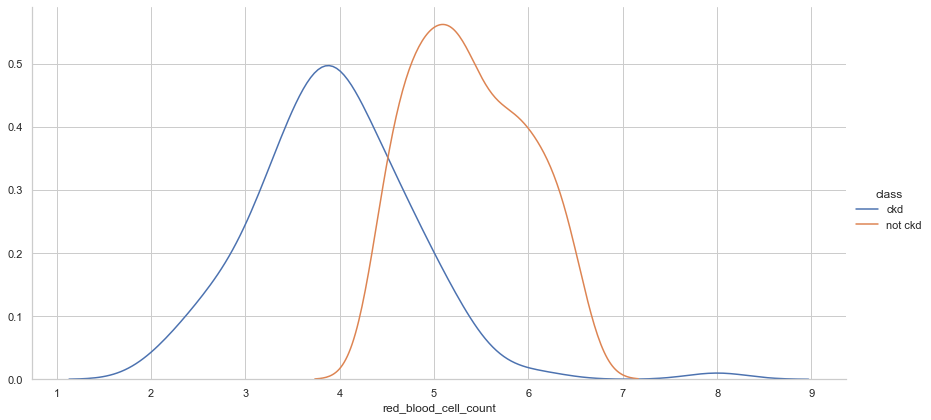

In [94]:
kde('red_blood_cell_count')

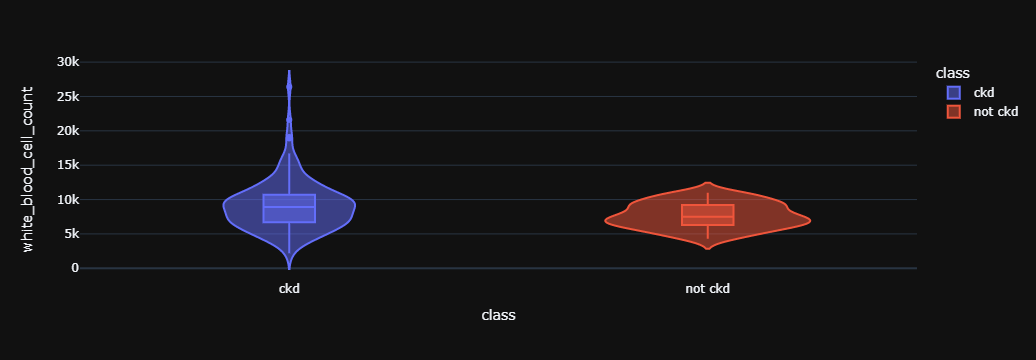

In [95]:
violin('white_blood_cell_count')

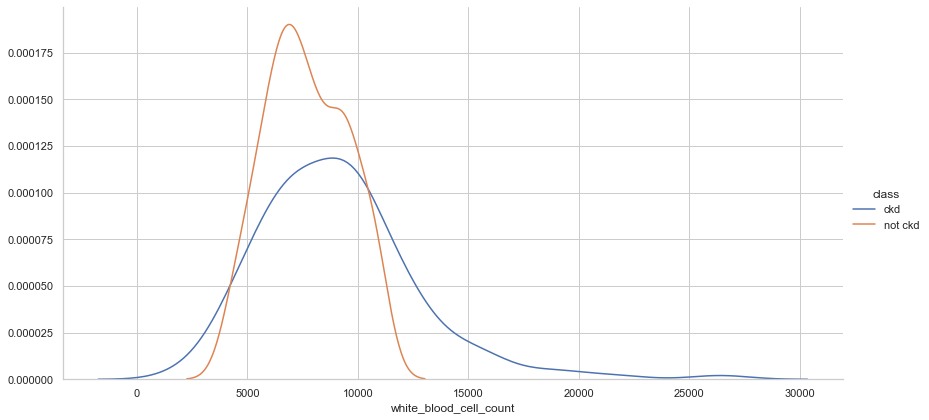

In [96]:
kde('white_blood_cell_count')

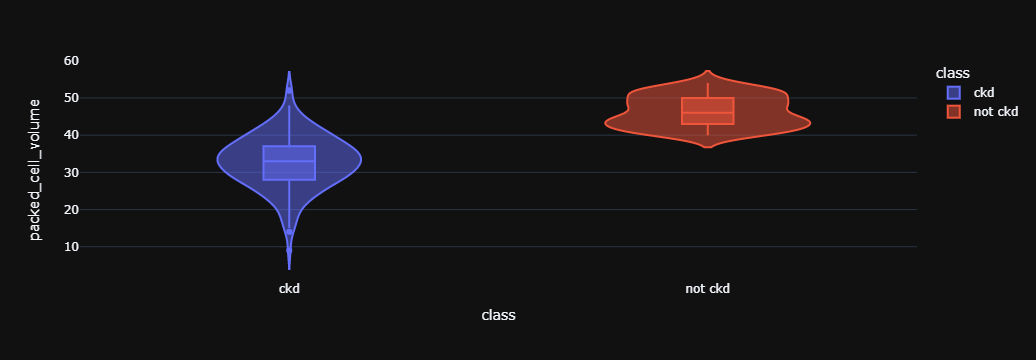

In [97]:
violin('packed_cell_volume')

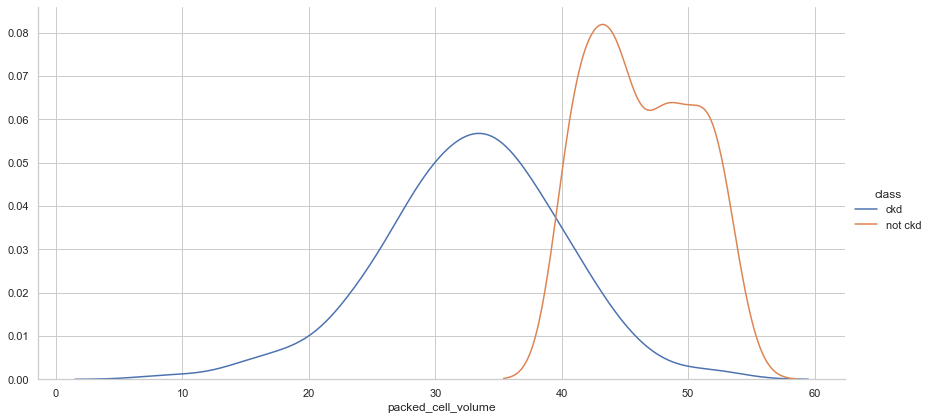

In [98]:
kde('packed_cell_volume')

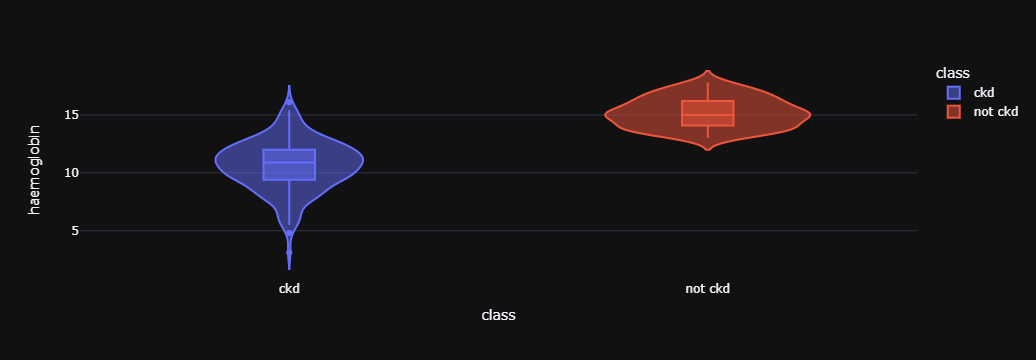

In [99]:
violin('haemoglobin')

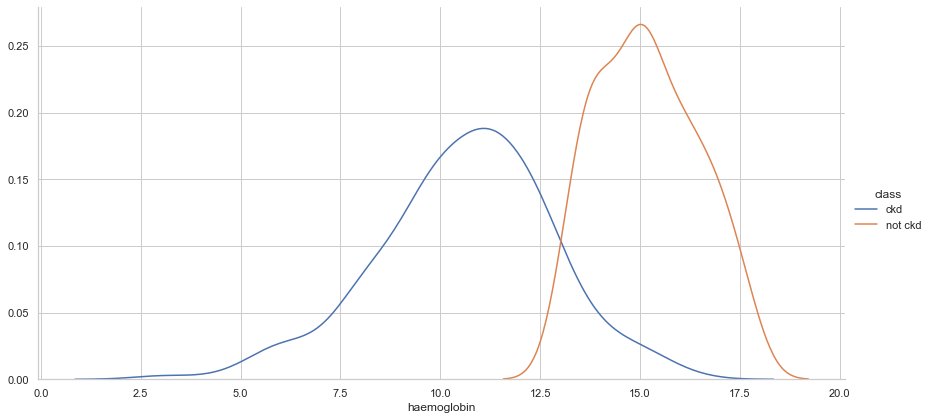

In [100]:
kde('haemoglobin')

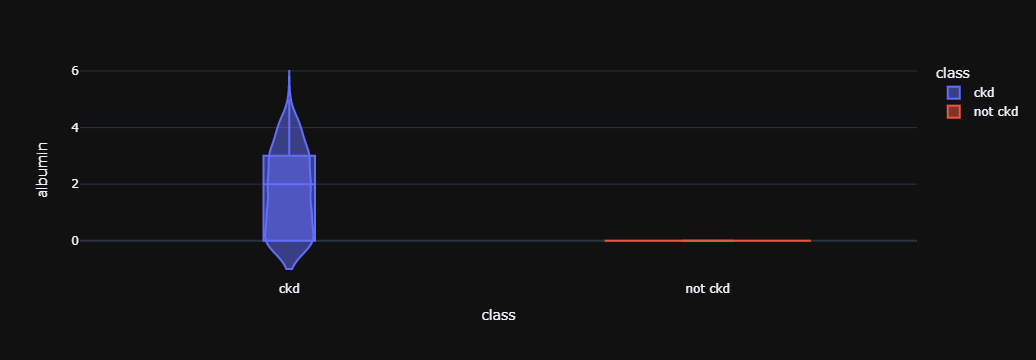

In [101]:
violin('albumin')

C:\Users\Suyin\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



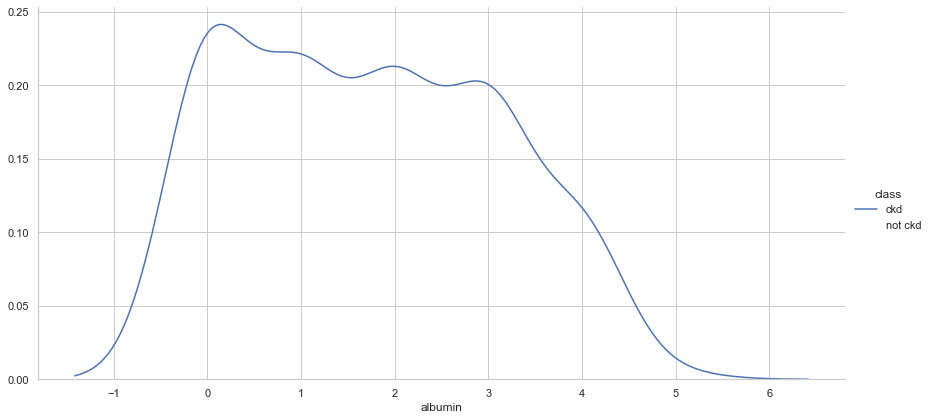

In [102]:
kde('albumin')

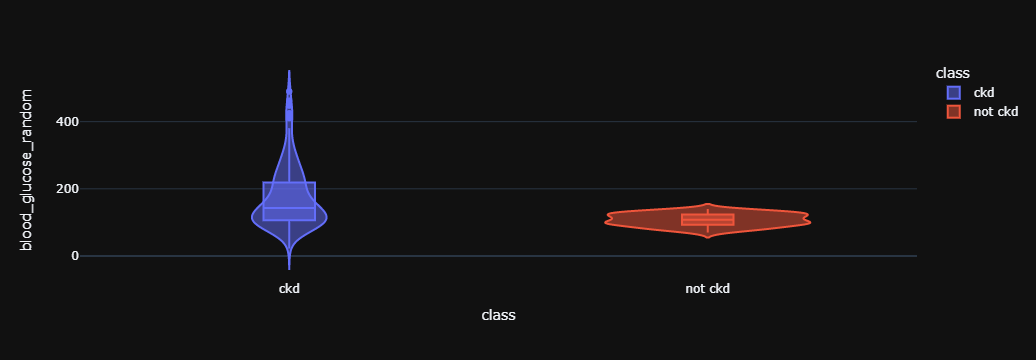

In [103]:
violin('blood_glucose_random')

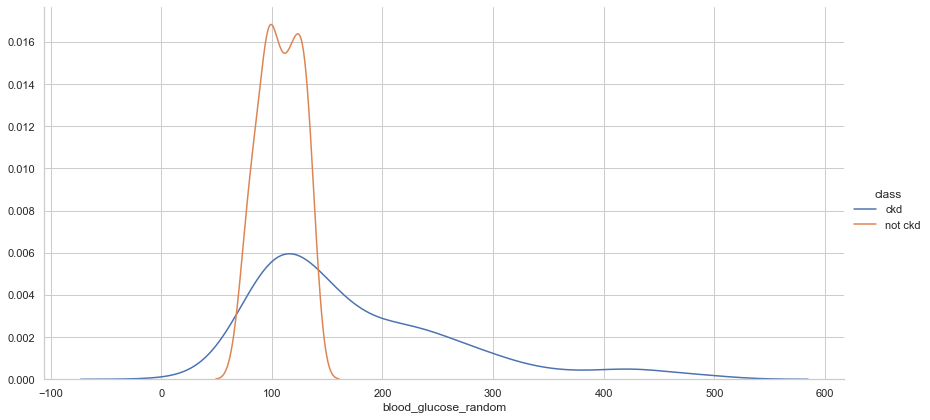

In [104]:
kde('blood_glucose_random')

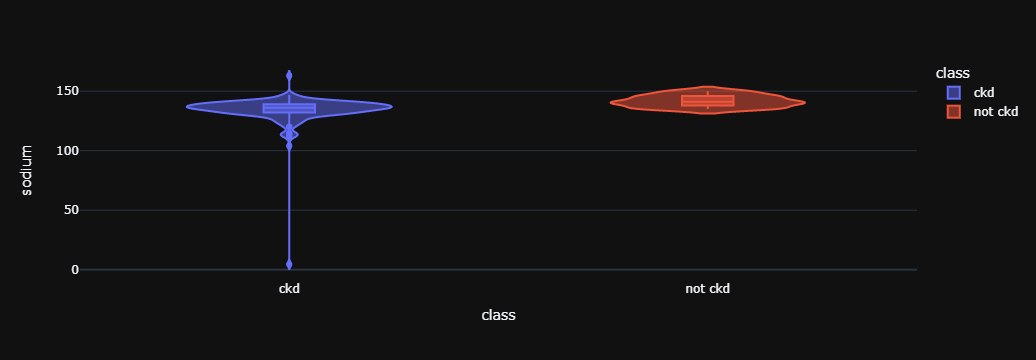

In [105]:
violin('sodium')

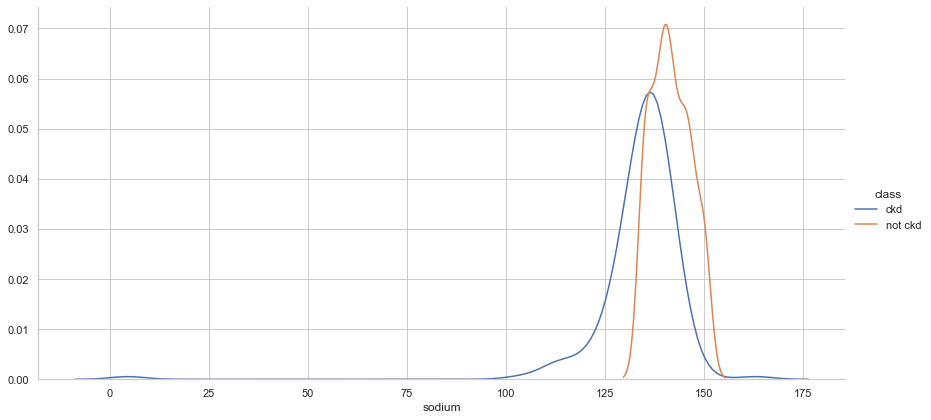

In [106]:
kde('sodium')

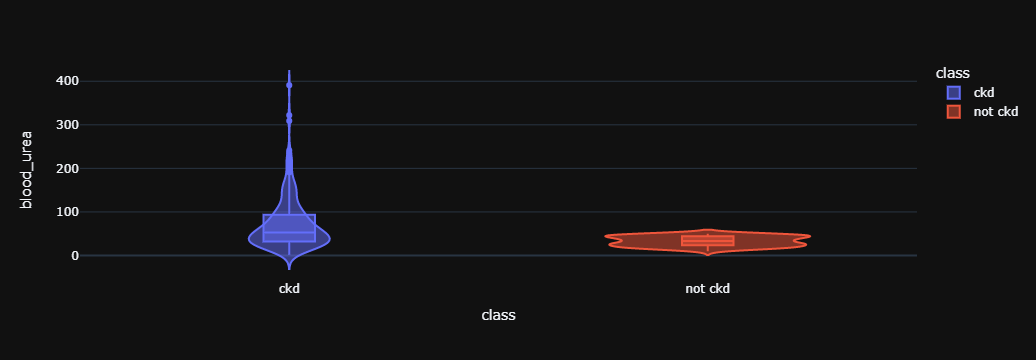

In [107]:
violin('blood_urea')

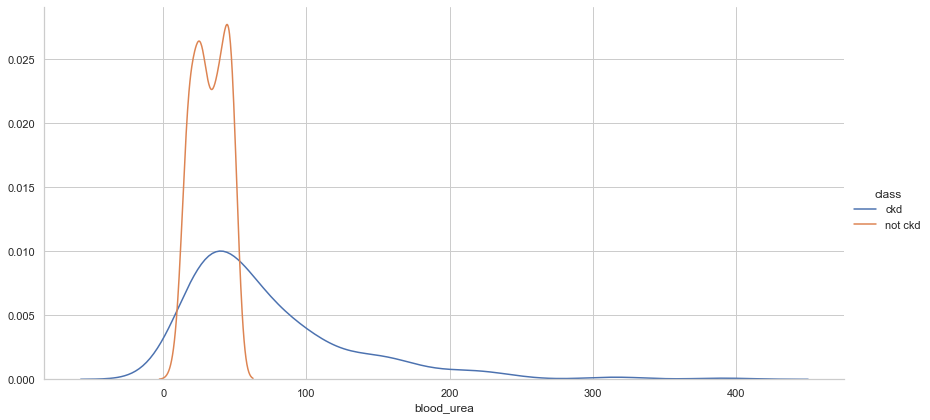

In [108]:
kde('blood_urea')

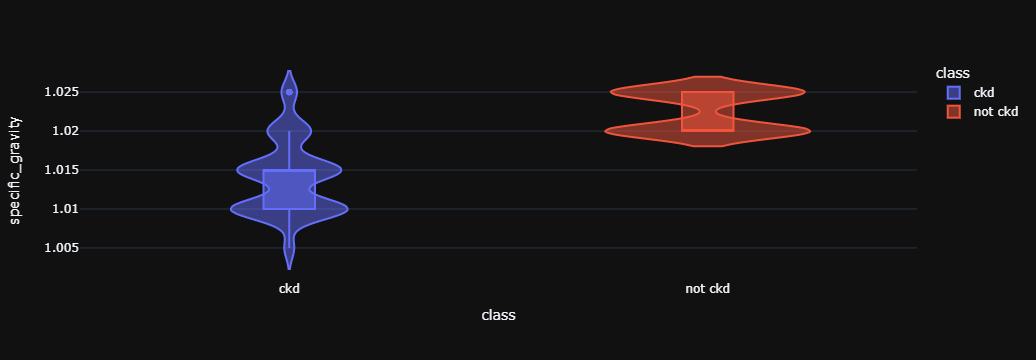

In [109]:
violin('specific_gravity')

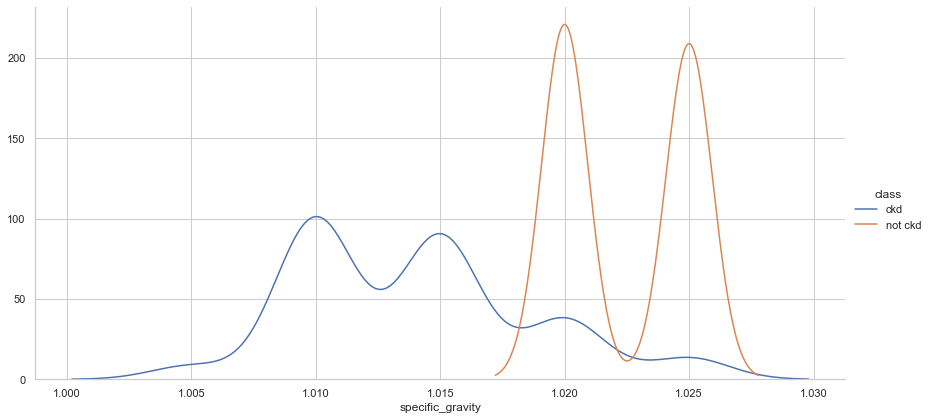

In [110]:
kde('specific_gravity')

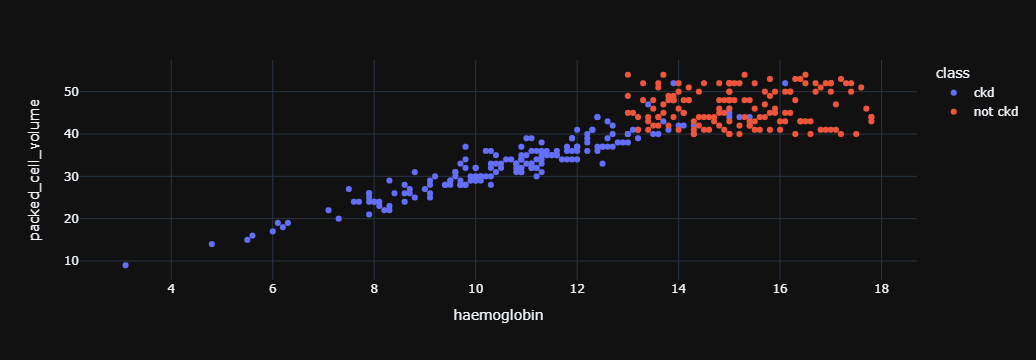

In [111]:
scatter('haemoglobin', 'packed_cell_volume')

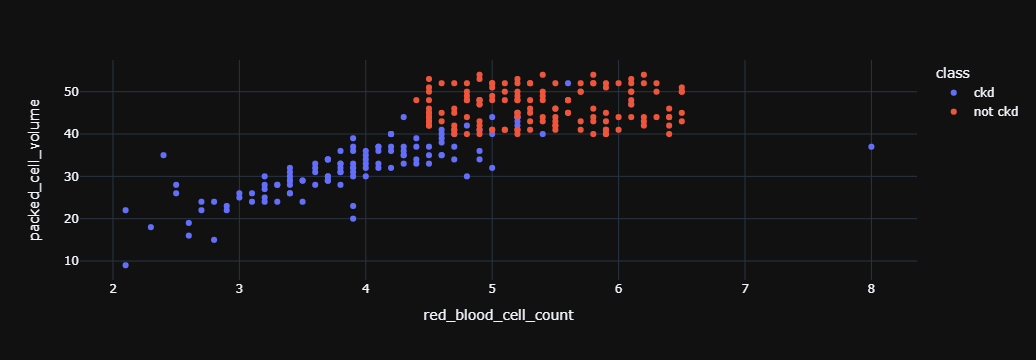

In [112]:
scatter('red_blood_cell_count', 'packed_cell_volume')

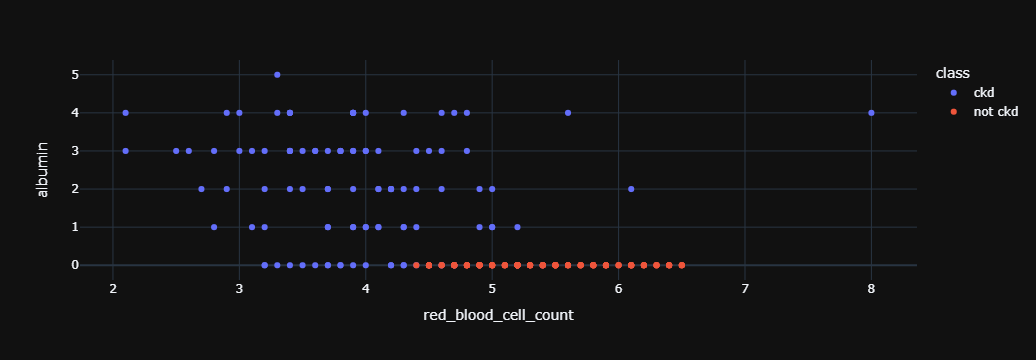

In [113]:
scatter('red_blood_cell_count', 'albumin')

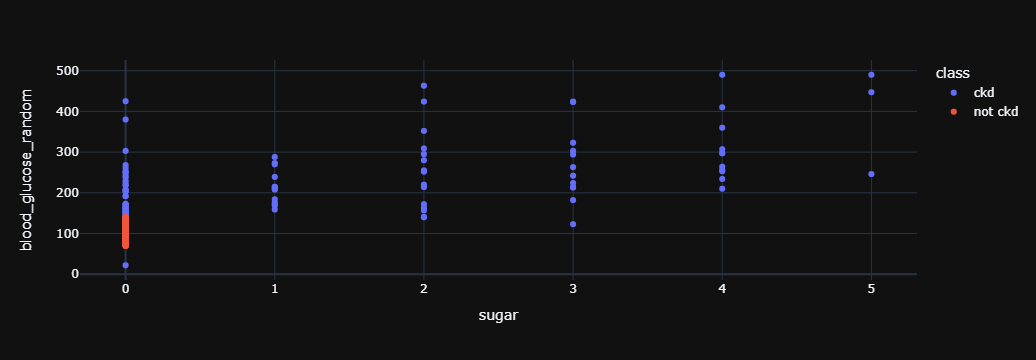

In [114]:
scatter('sugar', 'blood_glucose_random')

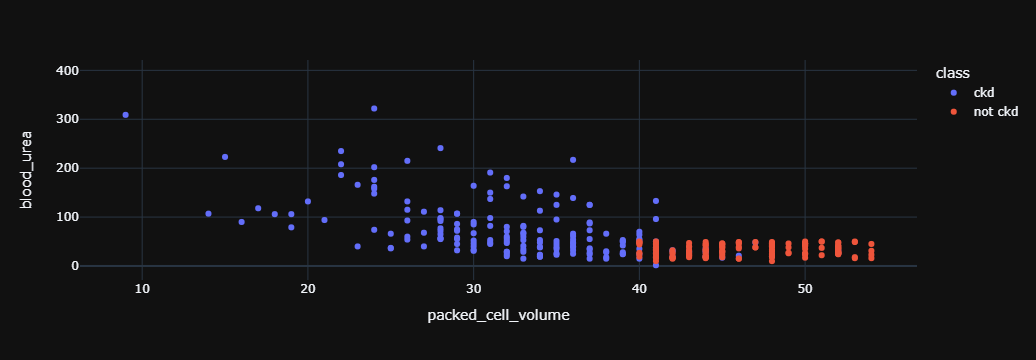

In [115]:
scatter('packed_cell_volume','blood_urea')

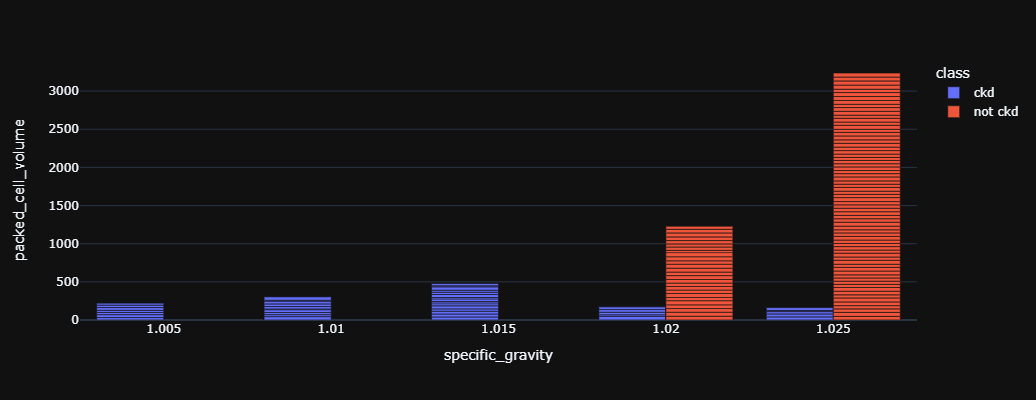

In [116]:
px.bar(data, x="specific_gravity", y="packed_cell_volume", color='class', barmode='group', template = 'plotly_dark', height = 400)

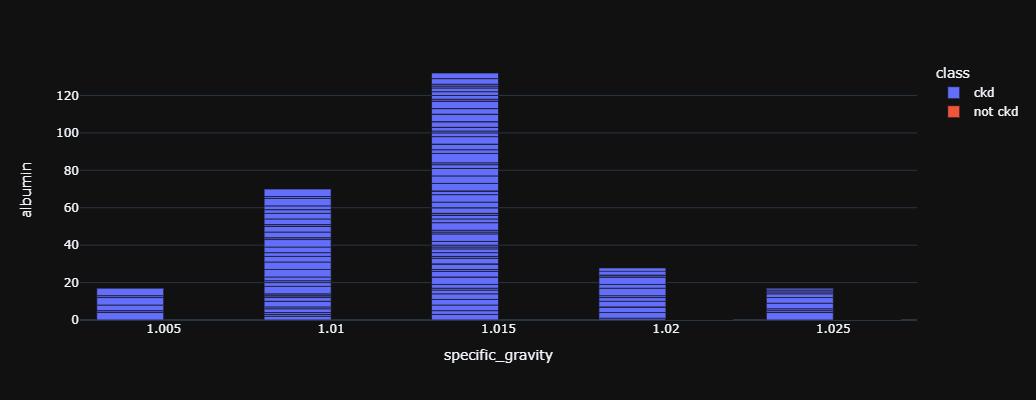

In [117]:
px.bar(data, x="specific_gravity", y="albumin", color='class', barmode='group', template = 'plotly_dark', height = 400)

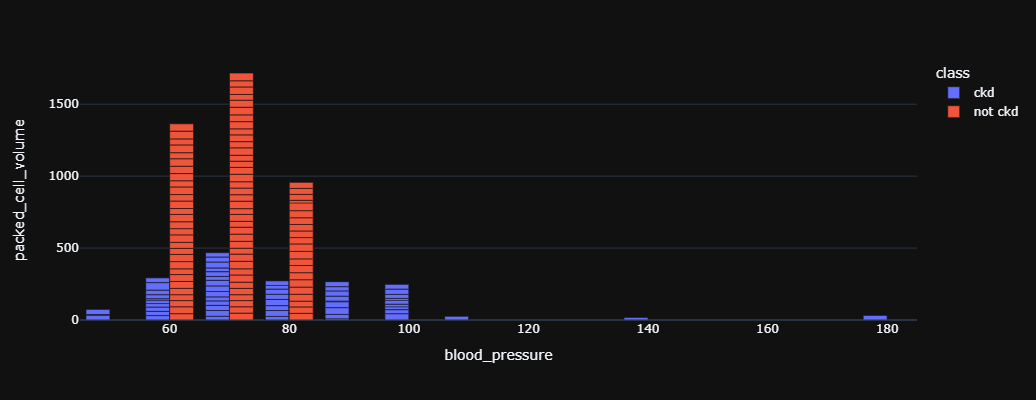

In [118]:
px.bar(data, x="blood_pressure", y="packed_cell_volume", color='class', barmode='group', template = 'plotly_dark', height = 400)

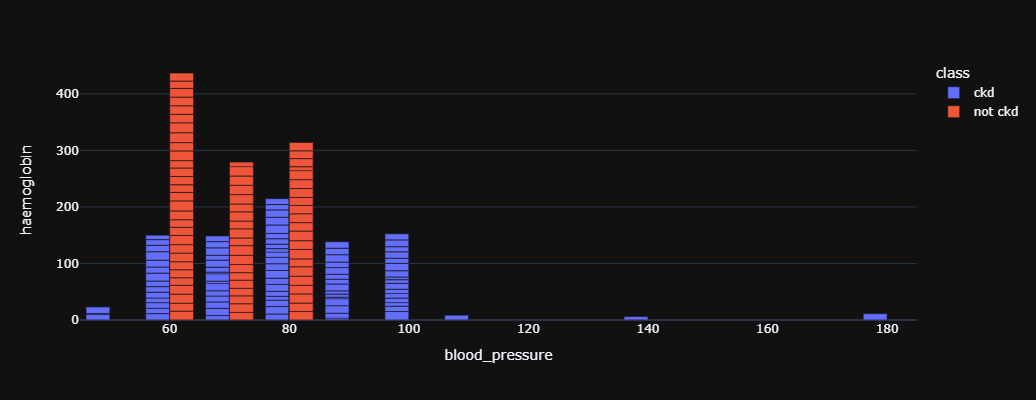

In [119]:
px.bar(data, x="blood_pressure", y="haemoglobin", color='class', barmode='group', template = 'plotly_dark', height = 400)

#  Building Models

In [162]:
# shuffle data
input_data_std=sklearn.utils.shuffle(input_data_std)

In [163]:
# Split data
y = input_data_std['class'].values
x = input_data_std.drop(['class'], axis=1).values


In [164]:
#build table

table1=prettytable.PrettyTable()
table1.field_names=['Random Forest','Accuracy','Recall','Precision']

table2=prettytable.PrettyTable()
table2.field_names=['KNN Classifier ','Accuracy','Recall','Precision']

table3=prettytable.PrettyTable()
table3.field_names=['ANN ','Accuracy','Recall','Precision']

## Random forest without PCA

In [165]:
# n trees=10
forest1 = RandomForestClassifier(n_estimators=10)
# K-fold cross-validation with 𝐾=3
from sklearn.model_selection import KFold
kf=KFold(n_splits=3, random_state=None, shuffle=True)

matrix_list=list()
accuracies=[]
kf_acc=[]
kf_recall=[]
kf_prec=[]

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    forest1.fit(x_train,y_train)
    matrix_list.append(confusion_matrix(y_test, forest1.predict(x_test)))
    kf_acc=accuracy_score(y_test,forest1.predict(x_test))
    kf_recall=recall_score(y_test,forest1.predict(x_test))
    kf_prec=precision_score(y_test,forest1.predict(x_test))
    
    accuracies=forest1.score(x_test,y_test)

acc_avg=np.mean(accuracies)
print("Random forest without PCA accuracy: {}%".format(round(acc_avg*100,2)))

matrix_list=np.average(np.array(matrix_list),axis=0)

Random forest without PCA accuracy: 97.73%


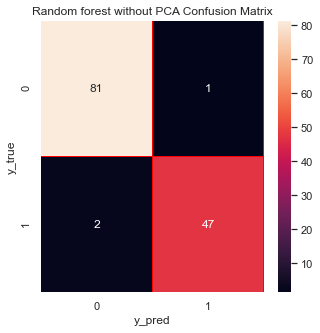

In [166]:
from sklearn import metrics
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(matrix_list,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Random forest without PCA Confusion Matrix")
plt.show()

In [167]:
acc=round(np.mean(kf_acc)*100,4)
recall=round(np.mean(kf_recall)*100,4)
prec=round(np.mean(kf_prec)*100,4)

table1.add_row(["Random Forest(n=10)without PCA",acc,recall,prec])
print(table1)

+--------------------------------+----------+--------+-----------+
|         Random Forest          | Accuracy | Recall | Precision |
+--------------------------------+----------+--------+-----------+
| Random Forest(n=10)without PCA | 97.7273  | 100.0  |  94.5455  |
+--------------------------------+----------+--------+-----------+


In [168]:
print(metrics.classification_report(y_test, forest1.predict(x_test), digits=3))

              precision    recall  f1-score   support

           0      1.000     0.963     0.981        80
           1      0.945     1.000     0.972        52

    accuracy                          0.977       132
   macro avg      0.973     0.981     0.976       132
weighted avg      0.979     0.977     0.977       132



## KNN without PCA

In [169]:
knn = KNeighborsClassifier(n_neighbors=5)

from sklearn.model_selection import KFold
kf=KFold(n_splits=3, random_state=None, shuffle=True)

matrix_list=list()
accuracies=[]
kf_acc=[]
kf_recall=[]
kf_prec=[]

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn.fit(x_train,y_train)
    matrix_list.append(confusion_matrix(y_test, knn.predict(x_test)))
    kf_acc=accuracy_score(y_test,knn.predict(x_test))
    kf_recall=recall_score(y_test,knn.predict(x_test))
    kf_prec=precision_score(y_test,knn.predict(x_test))
    
    accuracies=knn.score(x_test,y_test)

acc_avg=np.mean(accuracies)
print("KNN classifier without PCA accuracy: {}%".format(round(acc_avg*100,2)))

matrix_list=np.average(np.array(matrix_list),axis=0)

KNN classifier without PCA accuracy: 96.21%


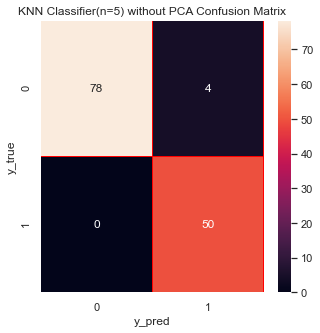

In [170]:
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(matrix_list,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("KNN Classifier(n=5) without PCA Confusion Matrix")
plt.show()

In [171]:
acc=round(np.mean(kf_acc)*100,4)
recall=round(np.mean(kf_recall)*100,4)
prec=round(np.mean(kf_prec)*100,4)

table2.add_row(["KNN Classifier(n=5) without PCA",acc,recall,prec])
print(table2)

+---------------------------------+----------+--------+-----------+
|         KNN Classifier          | Accuracy | Recall | Precision |
+---------------------------------+----------+--------+-----------+
| KNN Classifier(n=5) without PCA | 96.2121  | 100.0  |  90.9091  |
+---------------------------------+----------+--------+-----------+


In [172]:
print(metrics.classification_report(y_test, knn.predict(x_test), digits=3))

              precision    recall  f1-score   support

           0      1.000     0.939     0.969        82
           1      0.909     1.000     0.952        50

    accuracy                          0.962       132
   macro avg      0.955     0.970     0.960       132
weighted avg      0.966     0.962     0.962       132



## Random forest with PCA

In [173]:
# n trees=10
forest_pca = RandomForestClassifier(n_estimators=10)

In [174]:
# K-fold cross-validation with 𝐾=3
from sklearn.model_selection import KFold
kf=KFold(n_splits=3, random_state=None, shuffle=True)

matrix_list=list()
accuracies=[]
kf_acc=[]
kf_recall=[]
kf_prec=[]

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pca = PCA(n_components='mle')
    pca.fit(x_train)
    x_train=pca.transform(x_train)
    x_test=pca.transform(x_test)
    forest_pca.fit(x_train,y_train)
    matrix_list.append(confusion_matrix(y_test, forest_pca.predict(x_test)))
    kf_acc=accuracy_score(y_test,forest_pca.predict(x_test))
    kf_recall=recall_score(y_test,forest_pca.predict(x_test),average='weighted')
    kf_prec=precision_score(y_test,forest_pca.predict(x_test),average='weighted')
    
    accuracies=forest_pca.score(x_test,y_test)

acc_avg=np.mean(accuracies)
print("Random forest with PCA accuracy: {}%".format(round(acc_avg*100,2)))

matrix_list=np.average(np.array(matrix_list),axis=0)

Random forest with PCA accuracy: 95.45%


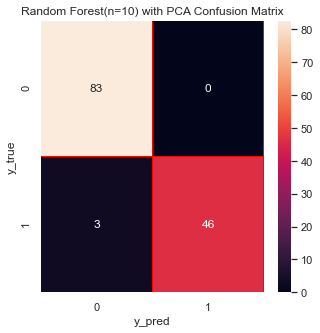

In [175]:
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(matrix_list,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Random Forest(n=10) with PCA Confusion Matrix")
plt.show()

In [176]:
acc=round(np.mean(kf_acc)*100,4)
recall=round(np.mean(kf_recall)*100,4)
prec=round(np.mean(kf_prec)*100,4)

table1.add_row(["Random Forest(n=10) with PCA",acc,recall,prec])
print(table1)

+--------------------------------+----------+---------+-----------+
|         Random Forest          | Accuracy |  Recall | Precision |
+--------------------------------+----------+---------+-----------+
| Random Forest(n=10)without PCA | 97.7273  |  100.0  |  94.5455  |
|  Random Forest(n=10) with PCA  | 95.4545  | 95.4545 |  95.7912  |
+--------------------------------+----------+---------+-----------+


In [177]:
print(metrics.classification_report(y_test, forest_pca.predict(x_test), digits=3))

              precision    recall  f1-score   support

           0      0.926     1.000     0.962        75
           1      1.000     0.895     0.944        57

    accuracy                          0.955       132
   macro avg      0.963     0.947     0.953       132
weighted avg      0.958     0.955     0.954       132



## KNN with PCA

In [178]:
knn_pca = KNeighborsClassifier(n_neighbors=5)

# K-fold cross-validation with 𝐾=3
from sklearn.model_selection import KFold
kf=KFold(n_splits=3, random_state=None, shuffle=True)

matrix_list=list()
accuracies=[]
kf_acc=[]
kf_recall=[]
kf_prec=[]

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pca = PCA(n_components='mle')
    pca.fit(x_train)
    x_train=pca.transform(x_train)
    x_test=pca.transform(x_test)
    knn_pca.fit(x_train,y_train)
    matrix_list.append(confusion_matrix(y_test, knn_pca.predict(x_test)))
    kf_acc=accuracy_score(y_test,knn_pca.predict(x_test))
    kf_recall=recall_score(y_test,knn_pca.predict(x_test),average='weighted')
    kf_prec=precision_score(y_test,knn_pca.predict(x_test),average='weighted')
    
    accuracies=knn_pca.score(x_test,y_test)

acc_avg=np.mean(accuracies)
print("KNN classifier with PCA accuracy: {}%".format(round(acc_avg*100,2)))

matrix_list=np.average(np.array(matrix_list),axis=0)

KNN classifier with PCA accuracy: 99.24%


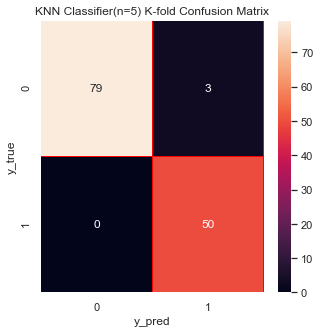

In [179]:
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(matrix_list,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("KNN Classifier(n=5) K-fold Confusion Matrix")
plt.show()

In [180]:
acc=round(np.mean(kf_acc)*100,4)
recall=round(np.mean(kf_recall)*100,4)
prec=round(np.mean(kf_prec)*100,4)

table2.add_row(["KNN Classifier(n=5) with PCA",acc,recall,prec])
print(table2)

+---------------------------------+----------+---------+-----------+
|         KNN Classifier          | Accuracy |  Recall | Precision |
+---------------------------------+----------+---------+-----------+
| KNN Classifier(n=5) without PCA | 96.2121  |  100.0  |  90.9091  |
|   KNN Classifier(n=5) with PCA  | 99.2424  | 99.2424 |  99.2567  |
+---------------------------------+----------+---------+-----------+


In [181]:
print(metrics.classification_report(y_test, knn_pca.predict(x_test), digits=3))

              precision    recall  f1-score   support

           0      1.000     0.988     0.994        80
           1      0.981     1.000     0.990        52

    accuracy                          0.992       132
   macro avg      0.991     0.994     0.992       132
weighted avg      0.993     0.992     0.992       132



## ANN

In [182]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [183]:
numfeat = x_train.shape[1]

model = keras.models.Sequential()
model.add(Dense(128,input_dim = numfeat,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=20,shuffle=True, verbose =2,batch_size=8)

Epoch 1/20
35/35 - 1s - loss: 0.3419 - accuracy: 0.9170 - val_loss: 0.1084 - val_accuracy: 0.9750 - 777ms/epoch - 22ms/step
Epoch 2/20
35/35 - 0s - loss: 0.0506 - accuracy: 0.9892 - val_loss: 0.0416 - val_accuracy: 0.9750 - 113ms/epoch - 3ms/step
Epoch 3/20
35/35 - 0s - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0350 - val_accuracy: 0.9917 - 112ms/epoch - 3ms/step
Epoch 4/20
35/35 - 0s - loss: 0.0127 - accuracy: 0.9964 - val_loss: 0.0302 - val_accuracy: 0.9917 - 116ms/epoch - 3ms/step
Epoch 5/20
35/35 - 0s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9833 - 125ms/epoch - 4ms/step
Epoch 6/20
35/35 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9833 - 135ms/epoch - 4ms/step
Epoch 7/20
35/35 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.9833 - 115ms/epoch - 3ms/step
Epoch 8/20
35/35 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.9833 - 138ms/epoch - 4ms/step
Epoch 9/20
35/3

<Figure size 720x720 with 0 Axes>

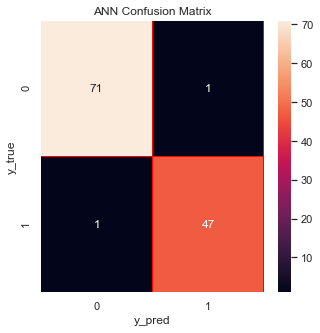

In [184]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, np.rint(y_pred))

plt.figure(figsize=(10,10))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.2,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("ANN Confusion Matrix")
plt.show()

In [185]:
acc=round(accuracy_score(y_test, np.rint(y_pred))*100,4)
recall=round(recall_score(y_test, np.rint(y_pred),average='weighted')*100,4)
prec=round(precision_score(y_test, np.rint(y_pred),average='weighted')*100,4)

table3.add_row(["Keras Sequential Model",acc,recall,prec])
print(table3)

+------------------------+----------+---------+-----------+
|          ANN           | Accuracy |  Recall | Precision |
+------------------------+----------+---------+-----------+
| Keras Sequential Model | 98.3333  | 98.3333 |  98.3333  |
+------------------------+----------+---------+-----------+
